In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# --- Constants ---
TIME_STEP_MINUTES = 5
TOTAL_HOURS = 24
NUM_STEPS = int(TOTAL_HOURS * (60 / TIME_STEP_MINUTES))
TIME_VECTOR_HOURS = np.linspace(0, TOTAL_HOURS, NUM_STEPS, endpoint=False)

In [32]:
# --- 1. Load and Process CSV Data to get Target Net Profile ---
def get_target_day_profile(csv_file_path, target_date_str, time_step_minutes_arg=TIME_STEP_MINUTES):
    try:
        df_actual = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        print(f"Error: The file {csv_file_path} was not found. Cannot create target profile.")
        return None

    df_actual['X-Data'] = pd.to_datetime(df_actual['X-Data'])
    
    target_col_original = 'TOTDemand(kWh/h)Value[kWh/h]'
    target_col_new = 'P_Net_from_CSV_kW'
    if target_col_original in df_actual.columns:
        df_actual.rename(columns={target_col_original: target_col_new}, inplace=True)
    else:
        print(f"Error: Target column '{target_col_original}' not found in CSV.")
        return None

    target_date = pd.to_datetime(target_date_str)
    df_day = df_actual[df_actual['X-Data'].dt.date == target_date.date()].copy()
    
    if df_day.empty:
        print(f"No data found for the target date: {target_date_str}")
        return None
        
    df_day.set_index('X-Data', inplace=True)
    
    voltage_col_original = 'AVrmsAvg[Volts]'
    voltage_col_new = 'AVrmsAvg_Volts' 
    if voltage_col_original in df_day.columns: # Check on df_day now
         df_day.rename(columns={voltage_col_original: voltage_col_new}, inplace=True)

    if voltage_col_new in df_day.columns: # Check on df_day
        anomalous_mask_day = (df_day[voltage_col_new] < 100)
        if anomalous_mask_day.any():
            print(f"Found and removing {anomalous_mask_day.sum()} anomalous rows from target day {target_date_str}.")
            df_day = df_day[~anomalous_mask_day]
            if df_day.empty: 
                print(f"All data for {target_date_str} was anomalous. Cannot proceed.")
                return None
    
    start_of_day = pd.Timestamp(target_date_str).normalize()
    full_day_timedelta_index = pd.to_timedelta(np.arange(0, 24 * 60, time_step_minutes_arg), unit='m')
    # Ensure index is timezone-naive if df_day.index is, or match timezone
    full_day_datetime_index = start_of_day + full_day_timedelta_index
    if df_day.index.tz is not None and full_day_datetime_index.tz is None:
        full_day_datetime_index = full_day_datetime_index.tz_localize(df_day.index.tz)
    elif df_day.index.tz is None and full_day_datetime_index.tz is not None:
         full_day_datetime_index = full_day_datetime_index.tz_localize(None)


    target_day_profile = df_day[target_col_new].reindex(full_day_datetime_index, method='ffill').fillna(method='bfill')
    if target_day_profile.isnull().any(): # If still NaNs (e.g. df_day was empty after anomaly removal)
        print(f"Warning: Target profile for {target_date_str} contains NaNs after processing. Using zeros.")
        target_day_profile = target_day_profile.fillna(0)

    target_day_profile.index = target_day_profile.index - target_day_profile.index[0] # Convert to TimedeltaIndex from start of day

    print(f"\nTarget Net Power Profile from CSV for {target_date_str} loaded (length {len(target_day_profile)}).")
    return target_day_profile

In [33]:
# --- 2. Individual Load Generation Functions ---
def generate_load_profile_basic(time_vector_hours, num_steps, p_rated, pf_run, 
                                schedule_on_indices, 
                                pf_inrush=None, inrush_factor=1.0):
    p_profile = np.zeros(num_steps)
    q_profile = np.zeros(num_steps)

    p_profile[schedule_on_indices] = p_rated
    q_profile[schedule_on_indices] = p_rated * np.tan(np.arccos(pf_run))
    
    if inrush_factor > 1.0 and pf_inrush is not None:
        on_transitions = np.diff(schedule_on_indices.astype(int), prepend=0)
        start_indices = np.where(on_transitions == 1)[0]
        
        for start_idx in start_indices:
            if start_idx < num_steps:
                p_profile[start_idx] = p_rated * inrush_factor
                q_profile[start_idx] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile

In [34]:
def get_house_load_profile(time_vector_hours, num_steps, **kwargs):
    pf_houses = 0.9
    p_house_single_peak = 2.5; p_house_single_day = 0.75; p_house_single_night = 0.5
    p_values = np.zeros(num_steps)
    for i, hour_of_day in enumerate(time_vector_hours):
        if 6 <= hour_of_day < 9: p_values[i] = 3 * p_house_single_peak
        elif 9 <= hour_of_day < 17: p_values[i] = 3 * p_house_single_day
        elif 17 <= hour_of_day < 21: p_values[i] = 3 * p_house_single_peak
        else: p_values[i] = 3 * p_house_single_night
    q_values = p_values * np.tan(np.arccos(pf_houses))
    return p_values, q_values, "1ph"

In [35]:
def get_security_fence_profile(time_vector_hours, num_steps, **kwargs):
    p_rated = 5.0; pf_fence = 0.95
    on_indices = np.ones(num_steps, dtype=bool)
    p, q = generate_load_profile_basic(time_vector_hours, num_steps, p_rated, pf_fence, on_indices)
    return p, q, "3ph"

In [36]:
def get_security_lights_profile(time_vector_hours, num_steps, **kwargs):
    p_total = 3.0; pf = 0.95
    on_indices = (time_vector_hours >= 18) | (time_vector_hours < 6)
    p, q = generate_load_profile_basic(time_vector_hours, num_steps, p_total, pf, on_indices)
    return p, q, "1ph"

In [37]:
def get_flexible_load_block_profile(time_vector_hours, num_steps, p_rated, pf_run, 
                                   total_op_hours, start_hour_param, 
                                   pf_inrush, inrush_factor):
    duration_steps = int(total_op_hours * 60 / TIME_STEP_MINUTES)
    start_step = int(start_hour_param * 60 / TIME_STEP_MINUTES)
    end_step = min(start_step + duration_steps, num_steps)
    
    on_indices = np.zeros(num_steps, dtype=bool)
    if start_step < num_steps : # Ensure start_step is a valid index
        on_indices[start_step:end_step] = True
    
    p, q = generate_load_profile_basic(time_vector_hours, num_steps, p_rated, pf_run, on_indices, pf_inrush, inrush_factor)
    return p, q

In [38]:
# --- 3. Automated Greedy Scheduler ---
def greedy_scheduler(target_gross_consumption_profile, load_definitions, fixed_load_names, flexible_load_order):
    num_steps = len(target_gross_consumption_profile)
    time_vector_hours = np.linspace(0, TOTAL_HOURS, num_steps, endpoint=False)
    
    simulated_p_profiles = pd.DataFrame(index=target_gross_consumption_profile.index)
    current_total_simulated_p = np.zeros(num_steps)
    final_schedules = {}

    print("\n--- Scheduling Fixed Loads ---")
    for load_name in fixed_load_names:
        config = load_definitions[load_name]
        p, q, phase = config['schedule_func'](time_vector_hours, num_steps, **config.get('params', {}))
        simulated_p_profiles[f'P_{load_name}'] = p
        current_total_simulated_p += p
        print(f"Scheduled fixed load: {load_name}")
        final_schedules[load_name] = "Fixed" # Or store actual schedule if varied

    print("\n--- Scheduling Flexible Loads (Greedy Approach) ---")
    for load_name in flexible_load_order:
        print(f"Attempting to schedule: {load_name}")
        config = load_definitions[load_name]
        best_schedule_start_hour = None
        best_p_for_this_load = np.zeros(num_steps)
        min_rmse_after_this_load = float('inf')

        p_rated = config['P_rated']
        pf_run = config['PF_run']
        total_op_hours = config['total_hours']
        pf_inrush = config.get('PF_inrush')
        inrush_factor = config.get('inrush_factor', 1.0)
        
        window_start_h, window_end_h = config['window']
        duration_h = total_op_hours
        
        last_possible_start_h = window_end_h - duration_h
        
        if window_start_h > last_possible_start_h :
            print(f"Warning: Load '{load_name}' duration ({duration_h}h) exceeds/equals window ({window_start_h}h-{window_end_h}h) allowing no valid start. Skipping.")
            simulated_p_profiles[f'P_{load_name}'] = best_p_for_this_load 
            final_schedules[load_name] = "Not scheduled (window too small)"
            continue

        possible_start_hours = np.arange(window_start_h, last_possible_start_h + (TIME_STEP_MINUTES/60.0), TIME_STEP_MINUTES/60.0)
        
        if not possible_start_hours.size:
            print(f"Warning: No valid start times for {load_name} within its window and duration. Skipping.")
            simulated_p_profiles[f'P_{load_name}'] = best_p_for_this_load
            final_schedules[load_name] = "Not scheduled (no valid starts)"
            continue

        for start_h_candidate in possible_start_hours:
            p_candidate, _ = config['schedule_func'](time_vector_hours, num_steps, 
                                                       p_rated=p_rated, pf_run=pf_run, 
                                                       total_op_hours=total_op_hours, 
                                                       start_hour_param=start_h_candidate,
                                                       pf_inrush=pf_inrush, 
                                                       inrush_factor=inrush_factor)
            
            temp_total_simulated_p = current_total_simulated_p + p_candidate
            current_rmse = np.sqrt(mean_squared_error(target_gross_consumption_profile.values, temp_total_simulated_p))
            
            if current_rmse < min_rmse_after_this_load:
                min_rmse_after_this_load = current_rmse
                best_schedule_start_hour = start_h_candidate
                best_p_for_this_load = p_candidate
        
        if best_schedule_start_hour is not None:
            current_total_simulated_p += best_p_for_this_load
            simulated_p_profiles[f'P_{load_name}'] = best_p_for_this_load
            final_schedules[load_name] = {'start_hour': best_schedule_start_hour, 'duration_hours': total_op_hours}
            print(f"  Best schedule for {load_name}: Start at {best_schedule_start_hour:.2f}h for {total_op_hours}h. Overall RMSE becomes: {min_rmse_after_this_load:.2f} kW")
        else:
            simulated_p_profiles[f'P_{load_name}'] = np.zeros(num_steps)
            final_schedules[load_name] = "Not scheduled (no improvement)"
            print(f"  Could not find an optimal schedule for {load_name} that improves RMSE.")

    simulated_p_profiles['P_Simulated_Gross_Consumption_kW'] = current_total_simulated_p
    simulated_p_profiles['P_Target_Gross_Consumption_kW'] = target_gross_consumption_profile.values
    
    print("\n--- Final Optimized Schedules (Greedy) ---")
    for load, schedule in final_schedules.items():
        print(f"Load: {load}, Schedule: {schedule}")
        
    return simulated_p_profiles

In [ ]:
def get_electrical_tools_load(time_vector_hours, num_steps, schedule_blocks=[(8,12), (13,17)]):
    p_rated = 1.5; pf_run = 0.8; inrush_factor = 2.0; pf_inrush = 0.65
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    for start_h, end_h in schedule_blocks:
        on_indices_block = (time_vector_hours >= start_h) & (time_vector_hours < end_h)
        p_profile[on_indices_block] = p_rated
        q_profile[on_indices_block] = p_rated * np.tan(np.arccos(pf_run))
        start_idx_block = np.where(on_indices_block)[0]
        if len(start_idx_block) > 0:
            p_profile[start_idx_block[0]] = p_rated * inrush_factor
            q_profile[start_idx_block[0]] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "3ph"

In [ ]:
def get_maize_cruncher_load(time_vector_hours, num_steps, schedule_blocks=[(8,11), (13,16)]):
    p_rated = 7.5; pf_run = 0.8; inrush_factor = 3.0; pf_inrush = 0.5
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    for start_h, end_h in schedule_blocks:
        on_indices_block = (time_vector_hours >= start_h) & (time_vector_hours < end_h)
        p_profile[on_indices_block] = p_rated
        q_profile[on_indices_block] = p_rated * np.tan(np.arccos(pf_run))
        start_idx_block = np.where(on_indices_block)[0]
        if len(start_idx_block) > 0:
            p_profile[start_idx_block[0]] = p_rated * inrush_factor
            q_profile[start_idx_block[0]] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "3ph"

In [ ]:
def get_feed_mixers_load(time_vector_hours, num_steps, schedule_blocks=[(8,11), (13,16)], num_active_mixers=3): # Default 3 mixers
    p_unit_rated = 7.5; 
    p_total_rated_active = p_unit_rated * num_active_mixers # Power based on active mixers
    pf_run = 0.8; inrush_factor = 3.0; pf_inrush = 0.5
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    for start_h, end_h in schedule_blocks: 
        on_indices_block = (time_vector_hours >= start_h) & (time_vector_hours < end_h)
        p_profile[on_indices_block] = p_total_rated_active
        q_profile[on_indices_block] = p_total_rated_active * np.tan(np.arccos(pf_run))
        start_idx_block = np.where(on_indices_block)[0]
        if len(start_idx_block) > 0:
            # Inrush based on number of active mixers starting
            p_profile[start_idx_block[0]] = p_total_rated_active * inrush_factor 
            q_profile[start_idx_block[0]] = (p_total_rated_active * inrush_factor) * np.tan(np.arccos(pf_inrush))
    
    return p_profile, q_profile, "3ph"


Target Net Power Profile from CSV for 2025-05-01 loaded (length 288).


C:\Users\hp\AppData\Local\Temp\ipykernel_7456\3558337449.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target_day_profile = df_day[target_col_new].reindex(full_day_datetime_index, method='ffill').fillna(method='bfill')


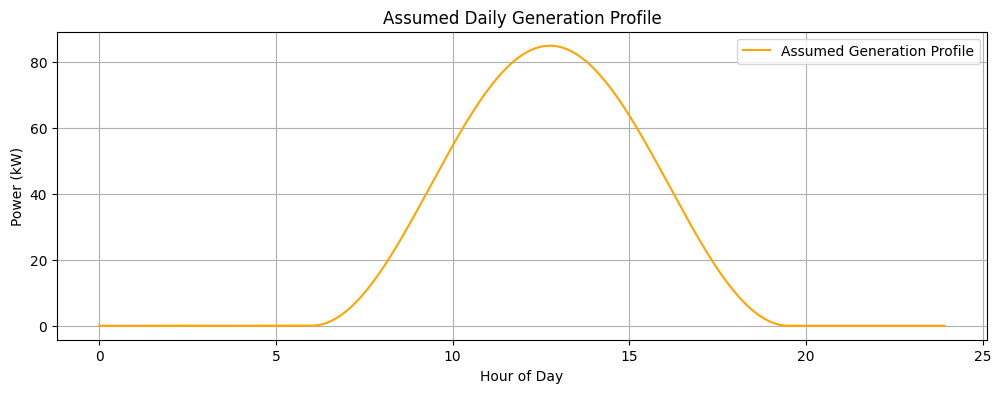

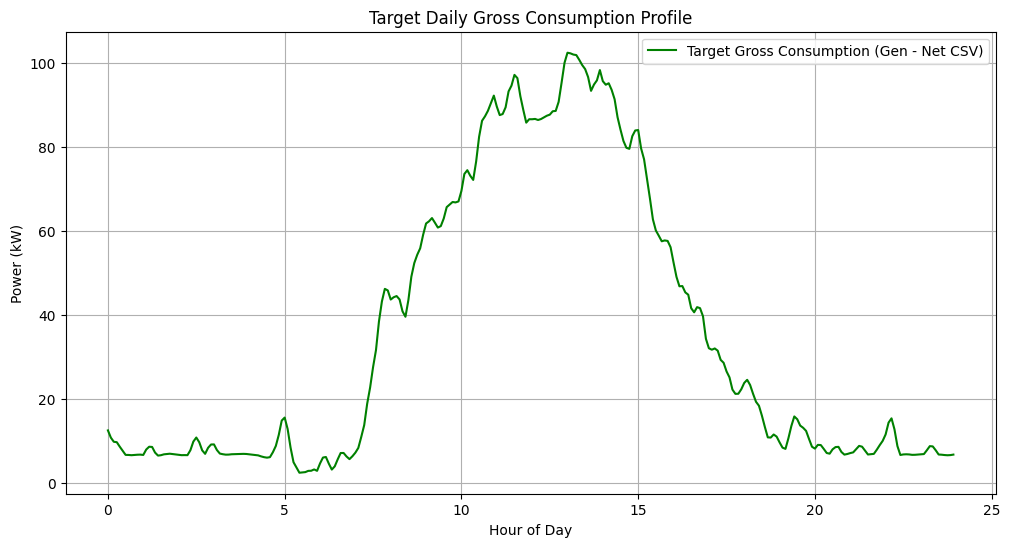


--- Scheduling Fixed Loads ---
Scheduled fixed load: Security_Fence
Scheduled fixed load: Security_Lights
Scheduled fixed load: Houses

--- Scheduling Flexible Loads (Greedy Approach) ---
Attempting to schedule: Feed_Mixers_Group
  Best schedule for Feed_Mixers_Group: Start at 9.58h for 6h. Overall RMSE becomes: 26.97 kW
Attempting to schedule: Maize_Cruncher
  Best schedule for Maize_Cruncher: Start at 10.58h for 6h. Overall RMSE becomes: 23.92 kW
Attempting to schedule: Cold_Room
  Best schedule for Cold_Room: Start at 7.58h for 10h. Overall RMSE becomes: 22.43 kW
Attempting to schedule: Electrical_Tools
  Best schedule for Electrical_Tools: Start at 8.67h for 8h. Overall RMSE becomes: 21.68 kW
Attempting to schedule: Borehole_Pump2
  Best schedule for Borehole_Pump2: Start at 8.67h for 6h. Overall RMSE becomes: 20.89 kW
Attempting to schedule: Borehole_Pump1
  Best schedule for Borehole_Pump1: Start at 9.08h for 5h. Overall RMSE becomes: 20.48 kW

--- Final Optimized Schedules (Gre

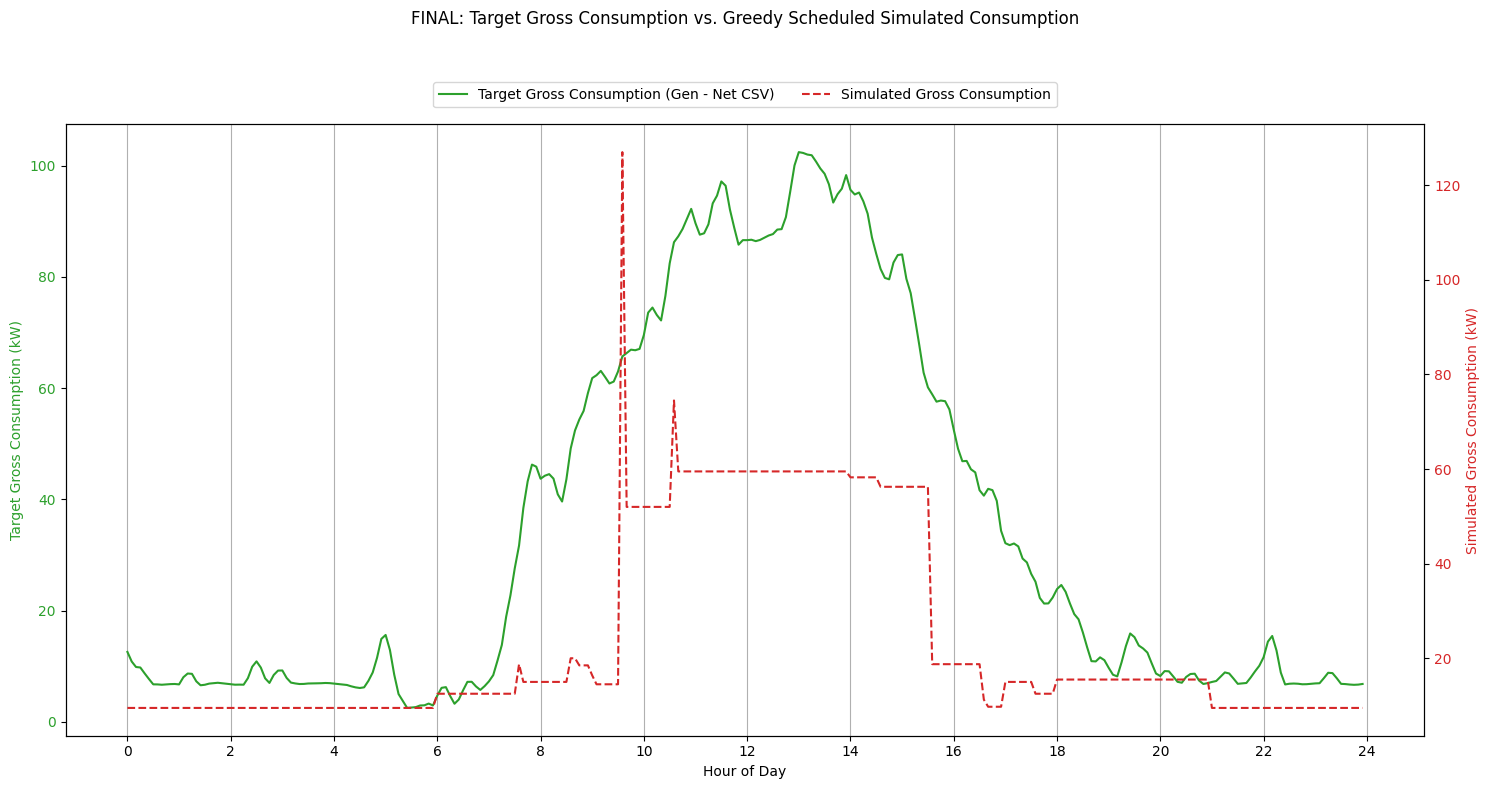


Final RMSE between Target Gross Consumption and Simulated Gross Consumption: 20.48 kW


In [ ]:
# --- Main Execution ---
if __name__ == '__main__':
    target_date_to_model = "2025-05-01" 
    target_net_profile_series = get_target_day_profile(r"c:\Users\hp\Desktop\REG108S\Project\MeasuredData_Filled.csv", target_date_to_model) 
    
    if target_net_profile_series is not None:
        num_steps_gen = len(target_net_profile_series)
        time_vector_gen_hours = np.linspace(0, TOTAL_HOURS, num_steps_gen, endpoint=False)
        
        # --- CRITICAL: Adjust these based on your farm & the previous target gross consumption plot ---
        peak_generation_kw = 85  # Example: Target peak was ~85kW
        daylight_start_h = 6.0   # Example: Earlier sunrise in May
        daylight_end_h = 19.5  # Example: Later sunset in May
        # --- End Critical Adjustments ---

        p_gen_assumed = np.zeros(num_steps_gen)
        for i, h_val in enumerate(time_vector_gen_hours):
            if daylight_start_h <= h_val < daylight_end_h:
                p_gen_assumed[i] = peak_generation_kw * (np.sin(np.pi * (h_val - daylight_start_h) / (daylight_end_h - daylight_start_h)))**2
        assumed_generation_profile_series = pd.Series(p_gen_assumed, index=target_net_profile_series.index)

        plt.figure(figsize=(12,4))
        plt.plot(assumed_generation_profile_series.index.total_seconds()/3600, assumed_generation_profile_series.values, label='Assumed Generation Profile', color='orange')
        plt.title('Assumed Daily Generation Profile')
        plt.xlabel('Hour of Day'); plt.ylabel('Power (kW)'); plt.grid(True); plt.legend(); plt.show()

        target_gross_consumption_profile = assumed_generation_profile_series - target_net_profile_series.values # Ensure numpy array for subtraction
        target_gross_consumption_profile[target_gross_consumption_profile < 0] = 0 

        plt.figure(figsize=(12,6))
        plt.plot(target_gross_consumption_profile.index.total_seconds()/3600, target_gross_consumption_profile.values, label='Target Gross Consumption (Gen - Net CSV)', color='green')
        plt.title('Target Daily Gross Consumption Profile')
        plt.xlabel('Hour of Day'); plt.ylabel('Power (kW)'); plt.grid(True); plt.legend(); plt.show()
        
        # In generate_combined_profile_with_assumed_gen
        # ...
        load_configs = {
            'Houses': {'schedule_func': get_house_load_profile, 'params': {}},
            'Security_Fence': {'schedule_func': get_security_fence_profile, 'params': {}},
            'Security_Lights': {'schedule_func': get_security_lights_profile, 'params': {}},

            # Loads with PRE-DEFINED (but potentially adjustable by you manually) block schedules
            # These will be treated like 'fixed' loads by the current simple greedy scheduler
            'Maize_Cruncher_FixedBlocks': {'schedule_func': get_maize_cruncher_load, # Assumes this function takes schedule_blocks
                                        'params': {'schedule_blocks': [(8,10), (12,14), (15,17)] }}, # 3x2h = 6h
            
            # Feed Mixers: 30 unit-hours total. Example: 3 units for 08-11, 3 units for 11-14, 4 units for 14-17
            'Feed_Mixers_B1': {'schedule_func': get_feed_mixers_load, # Assumes this can take num_active_mixers
                                'params': {'schedule_blocks': [(8,11)], 'num_active_mixers': 3}},
            'Feed_Mixers_B2': {'schedule_func': get_feed_mixers_load, 
                                'params': {'schedule_blocks': [(11,14)], 'num_active_mixers': 3}},
            'Feed_Mixers_B3': {'schedule_func': get_feed_mixers_load, 
                                'params': {'schedule_blocks': [(14,17)], 'num_active_mixers': 4}},

            'Electrical_Tools_FixedBlocks': {'schedule_func': get_electrical_tools_load, # Assumes this takes schedule_blocks
                                        'params': {'schedule_blocks': [(8.5,10.5),(11,13),(13.5,15.5),(16,18)]}}, # 4x2h=8h (adjusted to avoid exact overlap for clarity)

            # Loads to be OPTIMIZED by the greedy scheduler (single block placement)
            'Borehole_Pump1': {'P_rated': 1.25, 'PF_run': 0.8, 'PF_inrush':0.6, 'inrush_factor':2.5, 
                                'total_hours': 5, 'window':(6, 18), 'phase': '1ph',
                                'schedule_func': get_flexible_load_block_profile}, # This is the one for greedy
            'Borehole_Pump2': {'P_rated': 2.0, 'PF_run': 0.8, 'PF_inrush':0.6, 'inrush_factor':2.5,
                                'total_hours': 6, 'window':(6, 22), 'phase': '3ph',
                                'schedule_func': get_flexible_load_block_profile},
            'Cold_Room_FlexibleBlock': {'P_rated': 2.5, 'PF_run': 0.8, 'PF_inrush':0.6, 'inrush_factor':2.5, 'phase': '3ph',
                                        'total_hours': 10, 'window':(0, 24), # Greedy will find one 10-h block
                                        'schedule_func': get_flexible_load_block_profile},
        }

        # Adjust fixed_load_names and flexible_load_order accordingly
        fixed_load_names = ['Security_Fence', 'Security_Lights', 'Houses', 
                            'Maize_Cruncher_FixedBlocks', 'Feed_Mixers_B1', 'Feed_Mixers_B2', 'Feed_Mixers_B3',
                            'Electrical_Tools_FixedBlocks']
        flexible_load_order = ['Cold_Room_FlexibleBlock', 'Borehole_Pump2', 'Borehole_Pump1']
        # ... 
        
        flexible_load_order = [name for name in flexible_load_order if name in load_definitions]

        final_profiles_df = greedy_scheduler(target_gross_consumption_profile, 
                                             load_definitions, 
                                             fixed_loads, 
                                             flexible_load_order)
        
        if final_profiles_df is not None:
            fig, ax1 = plt.subplots(figsize=(15, 8))
            color = 'tab:green'
            ax1.set_xlabel('Hour of Day')
            ax1.set_ylabel('Target Gross Consumption (kW)', color=color)
            ax1.plot(final_profiles_df.index.total_seconds() / 3600, final_profiles_df['P_Target_Gross_Consumption_kW'], color=color, linestyle='-', label='Target Gross Consumption (Gen - Net CSV)')
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.grid(True, axis='x')

            ax2 = ax1.twinx()
            color = 'tab:red'
            ax2.set_ylabel('Simulated Gross Consumption (kW)', color=color)
            ax2.plot(final_profiles_df.index.total_seconds() / 3600, final_profiles_df['P_Simulated_Gross_Consumption_kW'], color=color, linestyle='--', label='Simulated Gross Consumption')
            ax2.tick_params(axis='y', labelcolor=color)
            
            fig.suptitle('FINAL: Target Gross Consumption vs. Greedy Scheduled Simulated Consumption')
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            # Positioning legend carefully to avoid too much overlap if possible
            ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2)

            plt.xticks(np.arange(0, 25, 2))
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

            rmse_final_match = np.sqrt(mean_squared_error(
                final_profiles_df['P_Target_Gross_Consumption_kW'], 
                final_profiles_df['P_Simulated_Gross_Consumption_kW']
            ))
            print(f"\nFinal RMSE between Target Gross Consumption and Simulated Gross Consumption: {rmse_final_match:.2f} kW")